# Scarcity 指标

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

人类利用科技手段不断的管理水资源，因此简单的物理缺水指数无法合理评估结构性水资源短缺在社会-水系统演化与过渡中所起的作用。因此，我们参考 Qin et al., 2019中提出的结构性缺水指数来评价流域缺水。该指数考虑了修建水库等管理措施，以及用水结构变化对水资源短缺情况评价的影响。

利用该方法指示水资源压力$I_S$，认为全流域的水资源压力是各区域SFV指数的均值，即：

$$ I_S = \frac{1}{4} * \sum_{i=1}^4 SFV_{i} $$

而计算某区域$i$的SFV指数，需要考虑三个权重相等的方面，标准化后计算SFV指数：
$$ SFV_i = a * V_i + b $$
$$ V_i = \frac{A_{i, normalize} + B_{i, normalize} + C_{i, normalize}}{3} $$
$$ a = \frac{1}{V_{max} - V_{min}}; $$
$$ b = \frac{1}{V_{min} - V_{max}} * V_{min} $$

（注：原文献中使用的常数为100，得到的指数结果位于$0~100$之间，这里为了和其余两指数保持$0~1$的相同数量级，将该系数调整为1）
- 首先是总的耗水量占区域多年平均径流量的比例：
$$ A_{i, j} = \frac{WU_{i,j}}{R_{i, avg}} $$

其中平均径流量用如下公式计算：
$$ R_{i, avg} = \frac{1}{j} * \sum_{j=1}^j R_{i} $$

- 其次是非弹性用水量占多年平均径流量的比例：
$$ B_{i, j} = \frac{WU_{inflexible}}{R_{i, avg}} $$

对于非弹性用水，Qin在文章中给出了如下划分：
For inflexible consumption, we include (according to Qin et al., 2019):    
- (1) Freshwater consumed for irrigation of perennial crops.
- (2) Water  evaporated during cooling of thermal power plants. √
- (3) Water evaporated from reservoirs.
- (4) Basic water allotments for humans and livestock. √

由于数据限制，本研究中，取其中（2）、（4）的和为非弹性用水。

- 最后，还要考虑水库的库容能力及调蓄作用对应对天然径流波动的积极影响：
$$ C1_{i, j} = \frac{R_{i, std}}{R_{i, avg}} $$

$$ C2_{i} = \frac{RC_{i}}{R_{i, avg}}, \ if RC < R_{i, avg} $$

$$ C2_{i} = 1, \ if RC >= R_{i, avg} $$

$$ C_i = C1_i * (1 - C2_i) $$

其中$RC_i$是该区域的水库总库容，$R_{i, std}$是多年径流的标准差，衡量天然径流的波动。

Qin, Y. et al. Flexibility and intensity of global water use. Nature Sustainability 2, 515–523 (2019).

## 数据加载

### 加载径流数据

In [2]:
# 加载径流和水库数据
use_cols = {
    "唐乃亥": "SR",  # 唐乃亥控制源区
    "头道拐": "UR",  # 头道拐控制上游
    "花园口": "MR",  # 花园口控制中游
    "利津": "DR",  # 利津控制下游
}
# 径流数据
measured_runoff = pd.read_csv(cfg.db.runoff, index_col="年份")
measured_runoff = measured_runoff.loc[:, use_cols.keys()]
measured_runoff.rename(use_cols, axis=1, inplace=True)

### 加载水库数据

In [3]:
# 水库库容数据
reservoirs_capacity = pd.read_csv(cfg.db.reservoirs, index_col=0)

# 水库库容累积相加数据
reservoirs_capacity_cumulating = reservoirs_capacity.cumsum()

### 加载耗水数据

In [4]:
consumptions = pd.read_csv(cfg.db.consumptions)

## 指数计算

### 分别计算三部分指数

In [5]:
## 计算三个部分的指数
from regimes_yrb.scarcity import (
    calculate_index_c,
    calculate_index_a,
    calculate_index_b,
)


index_a = calculate_index_a(runoff=measured_runoff, consumptions=consumptions)
index_b = calculate_index_b(
    runoff=measured_runoff,
    consumptions=consumptions,
    inflexible_wu=cfg.inflexible_wu,
)
index_c = calculate_index_c(
    runoff=measured_runoff, reservoirs=reservoirs_capacity_cumulating
)

### 整合成SFV

In [6]:
from regimes_yrb.scarcity import calc_sfv

# 计算 SFV
sfv, sfv_regions = calc_sfv(
    measured_runoff,
    consumptions,
    reservoirs_capacity_cumulating,
    cfg.inflexible_wu,
)

# 数据导出
sfv.to_csv(cfg.db.results.S)

[-0.0003944806679958905, 0.002063979743524372]

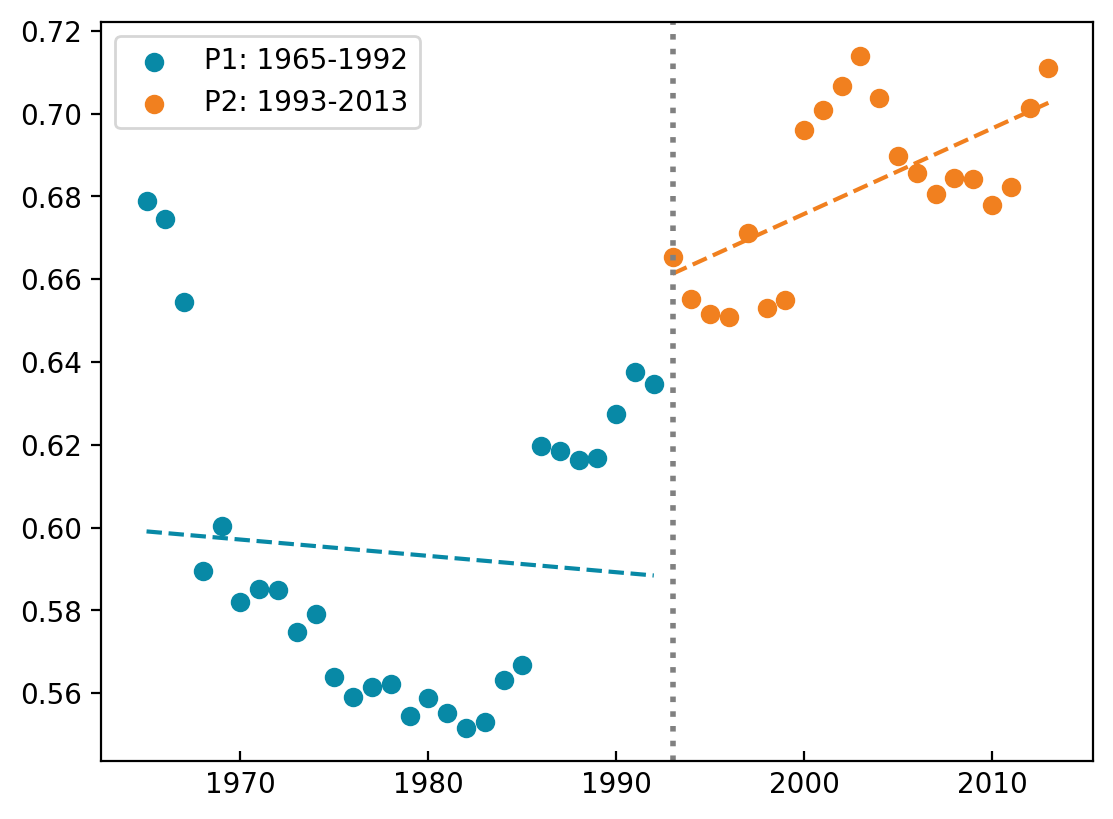

In [7]:
from regimes_yrb.plot import plot_pettitt_change_points, pettitt_changes


change_points = pettitt_changes(sfv)
plot_pettitt_change_points(
    sfv, change_points=change_points, colors=cfg.style.colors.period
)

## 贡献分解

In [8]:
from regimes_yrb.tools.statistic import calc_contribution_ratio

contribution = pd.DataFrame()
for start, end in [
    (cfg.start, cfg.breakpoints[0]),
    (cfg.breakpoints[0], cfg.breakpoints[1]),
    (cfg.breakpoints[1], cfg.end),
]:
    contri = calc_contribution_ratio(sfv_regions.loc[start:end])
    contribution[f"{start}-{end}"] = contri

contribution
contribution.to_csv(cfg.db.contribution.S)

,1966-1978,1978-2001,2001-2013
SR,2.471968e-16,2.003493e-16,0.000000
UR,9.095119e-01,8.993500e-01,-0.052792
MR,9.048805e-02,3.642337e-01,1.238553
DR,-0.000000e+00,-2.635837e-01,-0.185761


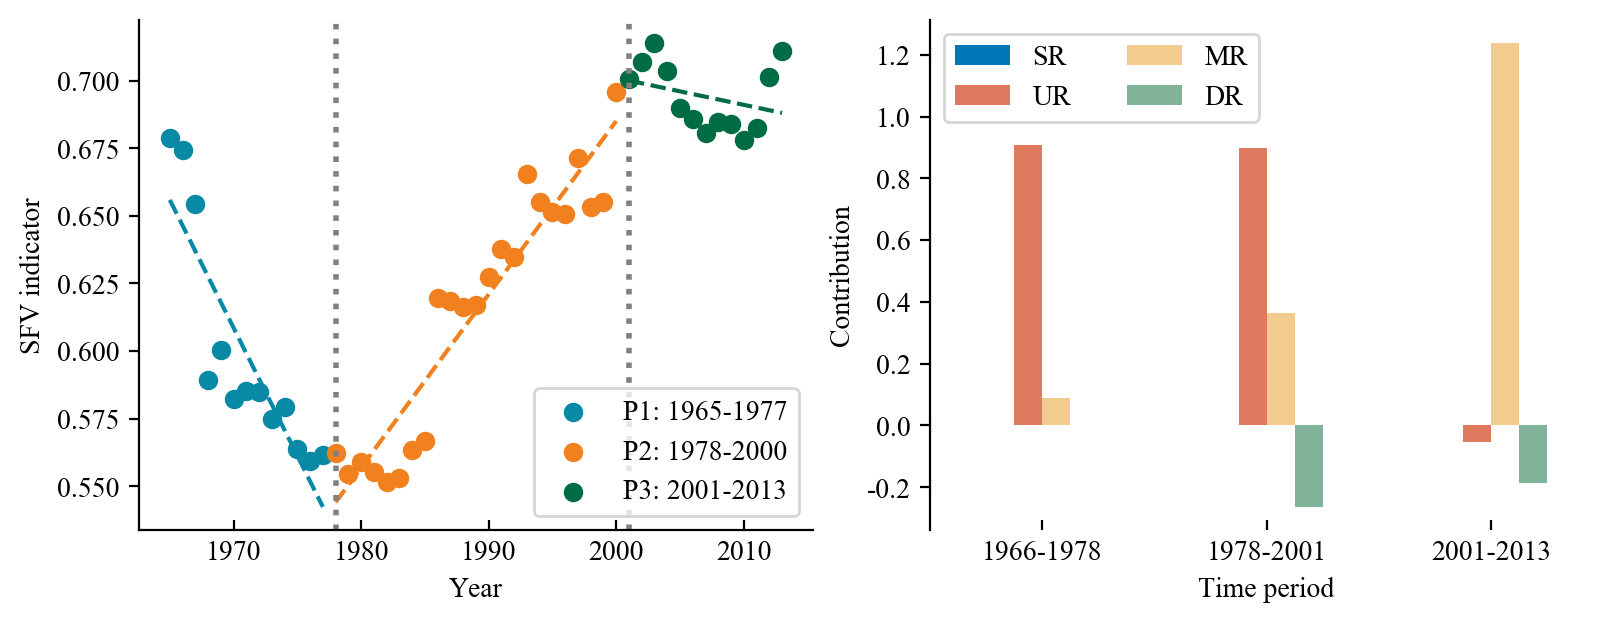

In [9]:
from matplotlib import pyplot as plt
from mksci_font import config_font

config_font()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)
plot_pettitt_change_points(
    sfv, change_points=cfg.breakpoints, colors=cfg.style.colors.period, ax=ax1
)

# contribution.rename({"SR": "源区", "UR": "上游", "MR": "中游", "DR": "下游"}, inplace=True)
ax = contribution.T.plot.bar(rot=0, color=cfg.style.colors.region, ax=ax2)
ax.legend(loc="upper left", ncol=2)
ax.set_ylabel("Contribution")
# ax.set_ylabel("贡献度")
ax1.set_xlabel("Year")
# ax1.set_xlabel("年份")
ax1.set_ylabel("SFV indicator")
# ax1.set_ylabel("SFV指数")
ax2.set_xlabel("Time period")
# ax2.set_xlabel("时段")

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["right"].set_visible(False)
ax1.spines["bottom"].set_visible(True)
plt.savefig("figures/sup/scarcity.png")
plt.show();